***Gaussian Process with unimodality constraint.***
=====

In [76]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn import preprocessing
import pickle
from hashlib import md5
import time
import os

def StanModel_cache(model_code, model_name=None, **kwargs):
    """Use just as you would `stan`"""
    
    if(os.path.isdir('./pkl_cache')==False):
        os.makedirs('./pkl_cache')
    
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = 'pkl_cache/cached-model-{}.pkl'.format(code_hash)
    else:
        cache_fn = 'pkl_cache/cached-{}-{}.pkl'.format(model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm

In [77]:
prior_code = """
functions {
    matrix joint_cov(real[] x,real alpha,real rho,real delta) {
        int N = size(x);
        matrix[N, N] K;
        real sq_alpha = square(alpha);
        for (i in 1:(N-1)) {
            K[i, i] = sq_alpha + delta;
            for (j in (i + 1):N) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho));
                K[j, i] = K[i, j];
            }
        }
        K[N,N] = sq_alpha + delta;
        return cholesky_decompose(K);
    }
}


data {
    int<lower=1> N;
    real x1[N];
}

transformed data {
    vector[N] mu;
    real delta=1e-8;
    mu=rep_vector(0,N);
}

parameters {
    real<lower=0> rho;
    real<lower=0> alpha;
    vector[N] eta;
}

transformed parameters{
    vector[N] f;
    {
        matrix[N, N] L_K;
        L_K = joint_cov(x1,alpha,rho,delta);
        f = mu + L_K*eta;
    }
}

model {    
    rho ~ inv_gamma(5,5);
    alpha ~ normal(0, 1);
    eta ~ normal(0, 1);
}
"""


In [78]:
prior_model = StanModel_cache(model_code=prior_code)

Using cached StanModel


In [79]:
uni_prior_code = """
functions {
    matrix joint_cov(real[] x,real alpha,real rho,real delta,int N1) {
        int N = size(x);
        int Nm = N-N1;
        matrix[N, N] K;
        real sq_alpha = square(alpha);
        for (i in 1:(N1-1)) {
            K[i, i] = sq_alpha + delta;
            for (j in (i + 1):N1) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho));
                K[j, i] = K[i, j];
            }
        }
        K[N1, N1] = sq_alpha + delta;
        
        for (i in (N1+1):N) {
            for (j in 1:N1) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho)) * ((x[j] - x[i])/ square(rho)) ;
                K[j, i] = K[i, j];
            }
        }
        
        for (i in (N1+1):(N-1)) {
            K[i, i] = (sq_alpha /square(rho))+ delta;
            for (j in (i+1):N) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho)) * ((1-square((x[i] - x[j])/ rho))/square(rho));
                K[j, i] = K[i, j];
            }
        }
        K[N, N] = (sq_alpha/square(rho)) + delta;
        return cholesky_decompose(K);
    }
    
}


data {
    int<lower=1> N1;
    real x1[N1];
    int<lower=1> Nm;
    real xm[Nm];
    real v;
}

transformed data {
    int<lower=1> N = N1 + Nm;
    vector[N] mu;
    real delta=1e-5;
    real x[N];
    real k= 10;
    
    
    for (n in 1:N1) x[n] = x1[n];
    for (n in 1:Nm) x[N1 + n] = xm[n];
    mu=rep_vector(0,N);
    
}

parameters {
    real<lower=0.00001> rho;
    real<lower=0.00001> alpha;
    vector[N] eta;
    real a;
    real b;
}

transformed parameters{
    
    real m[Nm];
    vector[N] f;
    {
        matrix[N, N] L_K;
        L_K = joint_cov(x,alpha,rho,delta,N1);
        f = mu + L_K*eta;
        
        for(i in 1:Nm){
            m[i] = a*xm[i]+b;
        }
        
    }
}

model {    
    rho ~ inv_gamma(5,5);
    alpha ~ normal(0, 1);
    eta ~ normal(0, 1);
    a ~ normal(0,1);
    b ~ normal(0,1);
    for(i in 1:Nm)
        target+=log(1-inv_logit(m[i])-inv_logit(f[N1+i]/v) + 2 * inv_logit(m[i])*inv_logit(f[N1+i]/v));
}
"""


In [80]:
uni_prior_model = StanModel_cache(model_code=uni_prior_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_19fb315759f881aeb7299bb424019de8 NOW.


In [81]:
cnt_xp = 20
xp = np.linspace(-10,4,cnt_xp)
    
prior_data = dict(
    N = len(xp),
    x1 = xp
)

In [82]:
prior_fit = prior_model.sampling(data=prior_data,iter=1000,chains=1)
print(prior_fit)

Inference for Stan model: anon_model_2dff1f44629ac0461f7c38f902f2a77c.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho       1.23    0.03   0.64    0.5   0.78   1.05   1.47   2.95  500.0   1.01
alpha     0.82    0.02   0.56   0.07   0.37   0.68    1.2   2.06  500.0    1.0
eta[0]    0.01    0.05   1.01  -2.12  -0.69   0.08   0.65    2.0  500.0    1.0
eta[1]   -0.09    0.05   1.02  -2.13  -0.74  -0.12   0.57   1.94  500.0    1.0
eta[2]   -0.03    0.05   1.03  -2.01  -0.72  -0.04   0.61   2.04  500.0    1.0
eta[3] -1.8e-3    0.04   0.96  -1.93  -0.67 6.8e-3   0.63   2.02  500.0    1.0
eta[4]   -0.07    0.04   0.98  -2.01   -0.7  -0.05   0.46   1.86  500.0    1.0
eta[5]    0.01    0.04   0.94  -1.89   -0.7   0.05   0.69   1.86  500.0    1.0
eta[6]   -0.05    0.05   1.01   -2.0  -0.76  -0.01    0.7   1.83  500.0    1.0
eta[7]   -0.02    0.04  

In [83]:
prior_arr = prior_fit.extract(permuted=True)
prior = prior_arr['f']

In [84]:
cnt_m = 30
xm = np.linspace(-10,10,cnt_m)
m = np.ones_like(xm,dtype=int)
v_value = 0.001

In [85]:
uni_prior_data = dict(
    N1 = len(xp),
    x1 = xp,
    Nm = cnt_m,
    xm = xm,
    m = m,
    v = v_value
)

In [86]:
uni_prior_fit = uni_prior_model.sampling(data=uni_prior_data,iter=1000,chains=1)
print(uni_prior_fit)

Inference for Stan model: anon_model_19fb315759f881aeb7299bb424019de8.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho       5.27    0.26   2.31   2.69   3.76   4.65    6.1  11.64   80.0    1.0
alpha     0.85    0.04   0.65   0.08   0.33   0.66   1.28   2.46  283.0    1.0
eta[0]    0.49    0.06   0.86  -1.15  -0.08   0.49    1.0   2.29  177.0    1.0
eta[1]    -0.8    0.05    0.6  -2.32  -1.11  -0.64  -0.37  -0.01  152.0    1.0
eta[2]   -0.35    0.08    0.9  -2.28  -0.86  -0.27   0.24   1.23  125.0   1.01
eta[3]   -0.31    0.07   0.93  -2.21  -0.95  -0.32    0.3   1.55  172.0    1.0
eta[4]   -0.54    0.07   0.97  -2.61  -1.07  -0.56   0.03    1.5  186.0    1.0
eta[5]   -0.37    0.11   0.96  -2.34  -0.99  -0.38   0.29   1.58   83.0    1.0
eta[6]   -0.54    0.07   0.97  -2.26  -1.23  -0.58   0.14   1.44  214.0    1.0
eta[7]   -0.36    0.05  

In [87]:
uni_prior_arr = uni_prior_fit.extract(permuted=True)
sim_uni_prior = uni_prior_arr['f']
_a = uni_prior_arr['a']
_b = uni_prior_arr['b']

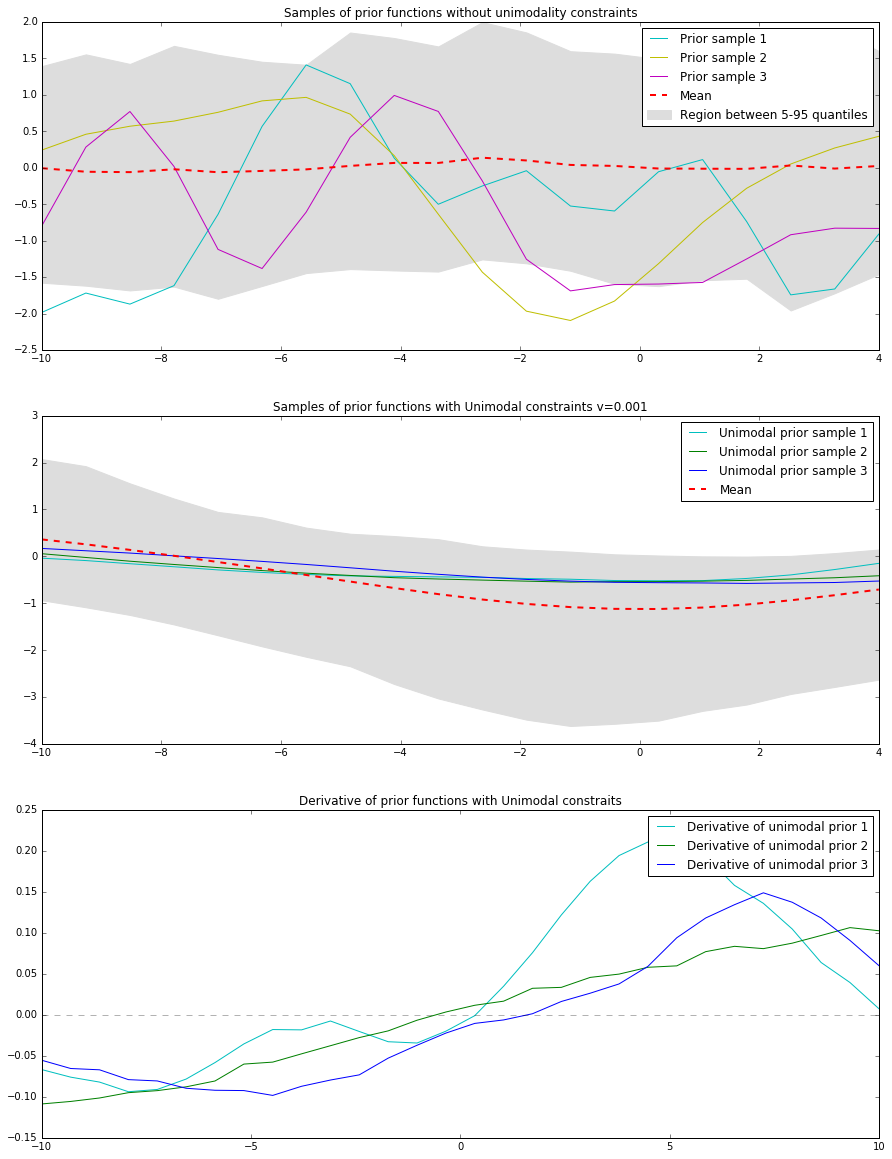

In [88]:
p = np.random.randint(sim_uni_prior.shape[0],size=3)
pp = np.random.randint(prior.shape[0],size=3)
pr_q5 = np.percentile(prior,5,axis=0)
pr_q95 = np.percentile(prior,95,axis=0)
pr_mean = np.mean(prior,axis=0)
m_pr_q5 = np.percentile(sim_uni_prior[0:,:cnt_xp],5,axis=0)
m_pr_q95 = np.percentile(sim_uni_prior[0:,:cnt_xp],95,axis=0)
m_pr_mean = np.mean(sim_uni_prior[0:,:cnt_xp],axis=0)


plt.figure(figsize=(15,20))

ax1 = plt.subplot(311)
plt.title('Samples of prior functions without unimodality constraints')
plt.plot(xp, prior[pp[0]], 'c',label="Prior sample 1")
plt.plot(xp, prior[pp[1]], 'y',label="Prior sample 2")
plt.plot(xp, prior[pp[2]], 'm',label="Prior sample 3")
plt.fill_between(xp, pr_q5, pr_q95, color="#dddddd",label="Region between 5-95 quantiles")
plt.plot(xp,pr_mean,'r--',lw=2,label="Mean" )
plt.legend()


plt.subplot(312)
plt.title('Samples of prior functions with Unimodal constraints v={}'.format(v_value))
plt.plot(xp, sim_uni_prior[p[0]][:cnt_xp], 'c',label="Unimodal prior sample 1")
plt.plot(xp, sim_uni_prior[p[1]][:cnt_xp], 'g',label="Unimodal prior sample 2")
plt.plot(xp, sim_uni_prior[p[2]][:cnt_xp], 'b',label="Unimodal prior sample 3")
plt.fill_between(xp, m_pr_q5, m_pr_q95, color="#dddddd")
plt.plot(xp,m_pr_mean,'r--',lw=2,label="Mean" )
plt.legend()

plt.subplot(313)
plt.title('Derivative of prior functions with Unimodal constraits')
plt.plot(xm, sim_uni_prior[p[0]][cnt_xp:], 'c',label="Derivative of unimodal prior 1")
plt.plot(xm, sim_uni_prior[p[1]][cnt_xp:], 'g',label="Derivative of unimodal prior 2")
plt.plot(xm, sim_uni_prior[p[2]][cnt_xp:], 'b',label="Derivative of unimodal prior 3")
plt.plot(plt.gca().get_xlim(),[0,0],'k--',alpha=0.3)
plt.legend()


# plt.subplot(414,sharex=ax1)
# xval = np.linspace(-10,4,20)
# print(xval)
# plt.title('Derivative of prior functions with Unimodal constraits')
# plt.plot(xval, _a[p[0]]*xval+_b[p[0]], 'c',label="Unimodality inducing line 1")
# plt.plot(xval, _a[p[1]]*xval+_b[p[1]], 'g',label="Unimodality inducing line 2")
# plt.plot(xval, _a[p[2]]*xval+_b[p[2]], 'b',label="Unimodality inducing line 3")
# plt.plot(plt.gca().get_xlim(),[0,0],'k--',alpha=0.3)
# plt.legend()



plt.legend()
plt.savefig("%s Unimodal Prior.png"%(time.ctime()))
plt.show()

# Posterior 

In [89]:
posterior_code = """
functions {
    matrix joint_cov(real[] x,real alpha,real rho,real delta) {
        int N = size(x);
        matrix[N, N] K;
        real sq_alpha = square(alpha);
        for (i in 1:(N-1)) {
            K[i, i] = sq_alpha + delta;
            for (j in (i + 1):N) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho));
                K[j, i] = K[i, j];
            }
        }
        K[N, N] = sq_alpha + delta;
        return cholesky_decompose(K);
    }
}

data {
    int<lower=1> N1;
    real x1[N1];
    vector[N1] y1;
    int<lower=1> N2;
    real x2[N2];
    real sig_var;
}

transformed data {
    vector[N1] mu;
    int<lower=1> N = N1 + N2;
    real x[N];
    real delta=1e-8;
    
    for (n in 1:N1) x[n] = x1[n];
    for (n in 1:N2) x[N1 + n] = x2[n];
    mu=rep_vector(0,N1);
}

parameters {
    real<lower=0> rho;
    real<lower=0> alpha;
    vector[N] eta;
    real<lower=0.000001> sigma;
}

transformed parameters{
     vector[N] f;
    {
        matrix[N, N] L_K = joint_cov(x,alpha,rho,delta);
        f = L_K * eta;
    }
}


model {    
    rho ~ inv_gamma(1, 2);
    alpha ~ normal(0, 1);
    sigma ~ normal(0,sig_var);
    eta ~ normal(0, 1);
    y1 ~ normal(f[1:N1], sigma);
}

generated quantities {
    vector[N2] y2;
    for(n in 1:N2)
        y2[n] = normal_rng(f[N1+n], sigma);
}
"""


In [90]:
posterior_model = StanModel_cache(model_code=posterior_code)

Using cached StanModel


In [134]:
uni_posterior_code = """
functions {
    matrix joint_cov(real[] x,real alpha,real rho,real delta,int Nm,int N) {
        int N1 = N-Nm;
        matrix[N, N] K;
        real sq_alpha = square(alpha);
        for (i in 1:(N1-1)) {
            K[i, i] = sq_alpha + delta;
            for (j in (i + 1):N1) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho));
                K[j, i] = K[i, j];
            }
        }
        K[N1, N1] = sq_alpha + delta;
        
        for (i in (N1+1):N) {
            for (j in 1:N1) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho)) * ((x[j] - x[i])/ square(rho)) ;
                K[j, i] = K[i, j];
            }
        }
        
        for (i in (N1+1):(N-1)) {
            K[i, i] = (sq_alpha /square(rho))+ delta;
            for (j in (i+1):N) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho)) * ((1-square((x[i] - x[j])/ rho))/square(rho));
                K[j, i] = K[i, j];
            }
        }
        K[N, N] = (sq_alpha/square(rho)) + delta;        
        return cholesky_decompose(K);
    }
}


data {
    int<lower=1> N1;
    real x1[N1];
    vector[N1] y1;
    int<lower=1> Nm;
    real xm[Nm];
    int<lower=1> N2;
    real x2[N2];
    real sig_var;
    real v;
}

transformed data {
    int<lower=1> N = N1 + Nm + N2;
    vector[N] mu;
    real delta=1e-4;
    real x[N];
    
    
    for (n in 1:N1) x[n] = x1[n];
    for (n in 1:N2) x[N1 + n] = x2[n];
    for (n in 1:Nm) x[N1+N2 + n] = xm[n];
    mu=rep_vector(0,N);
    
}

parameters {
    real<lower=0.00001> rho;
    real<lower=0.00001> alpha;
    vector[N] eta;
    real<lower=0.000001> sigma;
    real a;
    real b;
}

transformed parameters{
    real m[Nm];
    vector[N] f;
    {
        matrix[N, N] L_K;
        L_K = joint_cov(x,alpha,rho,delta,Nm,N);
        f = mu + L_K*eta;
        
        for(i in 1:Nm){
            m[i] = a*xm[i]+b;
        }
    }
}

model {    
    a ~ normal(0,1);
    b ~ normal(0,1);
    rho ~ inv_gamma(1,2);
    alpha ~ normal(0, 1);
    eta ~ normal(0, 1);
    sigma ~ normal(0,sig_var);
    y1 ~ normal(f[1:N1], sigma);
    
    for(i in 1:Nm)
        target+= log((1-inv_logit(m[i]/v))*(1-inv_logit(f[N1+N2+i]/v)) + inv_logit(m[i]/v)*inv_logit(f[N1+N2+i]/v));

    
}

generated quantities{
    vector[N2] y2;
    for(n in 1:N2)
        y2[n] = normal_rng(f[N1+n],sigma);
}
"""

In [135]:
uni_posterior_model = StanModel_cache(model_code=uni_posterior_code)

Using cached StanModel


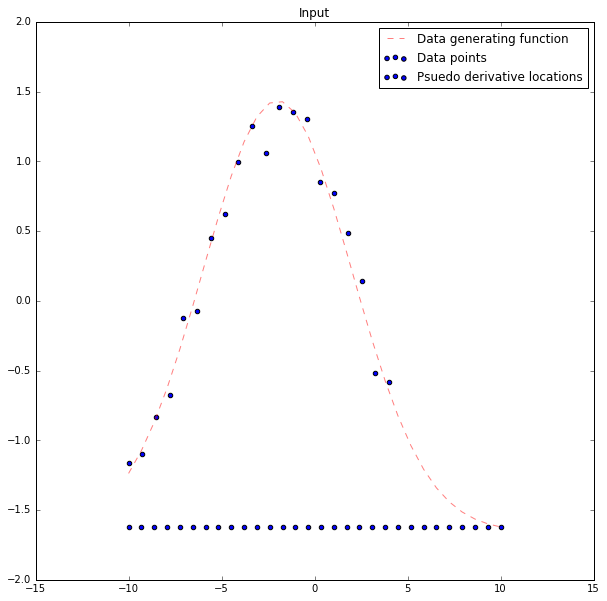

In [149]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def func(x):
    return gaussian(x,-2,4) #+ gaussian(x,-3,0.5)*0.02



xdata = np.linspace(-10,4,20)
ydata = func(xdata) + np.random.normal(0,0.005,size=len(xdata))
x = np.linspace(-10,10,30)
y = func(x) 
ycombined = preprocessing.scale(np.append(ydata,y))
ydata = ycombined[:len(xdata)]
y = ycombined[len(xdata):]

plt.figure(figsize=(10,10))
plt.scatter(xdata,ydata,label="Data points")
plt.plot(x,y,'r--',alpha=0.5,label="Data generating function")
plt.scatter(xm,np.zeros_like(xm)+np.min(ycombined),label="Psuedo derivative locations")
plt.title('Input')

plt.legend()
plt.savefig("%s Input data points.png"%(time.ctime()))

plt.show()

In [150]:
sig =0.05
v= 0.001

posterior_data = dict(
    N1 = len(xdata),
    x1 = xdata,
    y1 = ydata,
    N2 = len(x),
    x2 = x,
    sig_var = sig
)

uni_posterior_data = dict(
    N1 = len(xdata),
    x1 = xdata,
    y1 = ydata,
    Nm = len(xm),
    xm = xm,
    m = m,
    N2 = len(x),
    x2 = x,
    v = v,
    sig_var = sig
)

In [151]:
posterior_fit = posterior_model.sampling(data=posterior_data,iter=1000,chains=1)
print(posterior_fit)

Inference for Stan model: anon_model_f2c9e4d4a8ca5ef24cd8c45a8059b229.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho       4.86    0.09   1.11   2.83   4.04   4.87   5.68   7.02  144.0    1.0
alpha      1.3    0.04   0.43   0.61   0.99   1.27   1.57   2.16  147.0    1.0
eta[0]   -1.03    0.03   0.38  -1.96  -1.21  -0.95  -0.76  -0.53  130.0    1.0
eta[1]    0.71    0.02    0.4  -0.05   0.44   0.69   0.98   1.52  323.0    1.0
eta[2]    1.05    0.03   0.65  -0.06   0.56    1.0   1.48   2.44  367.0    1.0
eta[3]    0.57    0.04   0.82  -1.04   0.04   0.53    1.1   2.18  500.0    1.0
eta[4]    0.23    0.05   0.91  -1.72   -0.4   0.28   0.84   2.01  376.0    1.0
eta[5]    0.08    0.06   0.99  -1.84  -0.63   0.04    0.8   2.03  267.0    1.0
eta[6]   -0.02    0.04   0.95  -1.87  -0.69   0.02   0.61    1.8  500.0    1.0
eta[7]   -0.27    0.05  

In [152]:
uni_posterior_fit = uni_posterior_model.sampling(data=uni_posterior_data,iter=1000,chains=1)
print(uni_posterior_fit)

Inference for Stan model: anon_model_94017ad274020ea2af0c9752a11522c1.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho       5.62    0.14   1.09   3.47   4.88   5.71   6.38   7.63   57.0    1.0
alpha      1.6    0.04   0.45   0.89   1.26   1.54   1.86   2.63  110.0    1.0
eta[0]   -0.82    0.03   0.24  -1.32  -0.96  -0.78  -0.65  -0.46   82.0    1.0
eta[1]    0.74    0.02    0.3   0.22   0.53   0.73   0.92   1.35  177.0    1.0
eta[2]    0.95    0.06   0.71  -0.41   0.44   0.91   1.47   2.46  154.0    1.0
eta[3]    0.59    0.07   0.86  -1.08   0.06   0.59   1.19   2.23  173.0    1.0
eta[4]    0.36    0.06   0.87  -1.35   -0.2   0.41   0.92   1.98  216.0    1.0
eta[5]    0.11    0.05   0.85  -1.68  -0.46   0.09   0.64   1.86  258.0    1.0
eta[6]    0.11    0.06   0.95  -1.88   -0.5    0.1   0.76   1.88  271.0    1.0
eta[7]   -0.24    0.06  

In [153]:
sim_posterior = posterior_fit.extract(permuted=True)['y2']
p_mean = np.mean(sim_posterior,axis=0)
p_std = np.std(sim_posterior,axis=0)
p_q5 = np.percentile(sim_posterior, 5, axis=0)
p_q95 = np.percentile(sim_posterior, 95, axis=0)


In [154]:
uni_sim_posterior = uni_posterior_fit.extract(permuted=True)['y2']
u_a = np.mean(uni_posterior_fit.extract(permuted=True)['a'])
u_b = np.mean(uni_posterior_fit.extract(permuted=True)['b'])
u_p_mean = np.mean(uni_sim_posterior,axis=0)
u_p_std = np.std(uni_sim_posterior,axis=0)
u_p_q5 = np.percentile(uni_sim_posterior, 5, axis=0)
u_p_q95 = np.percentile(uni_sim_posterior, 95, axis=0)
print(u_a,u_b)

(-0.62818378615982395, -0.99637218750905343)


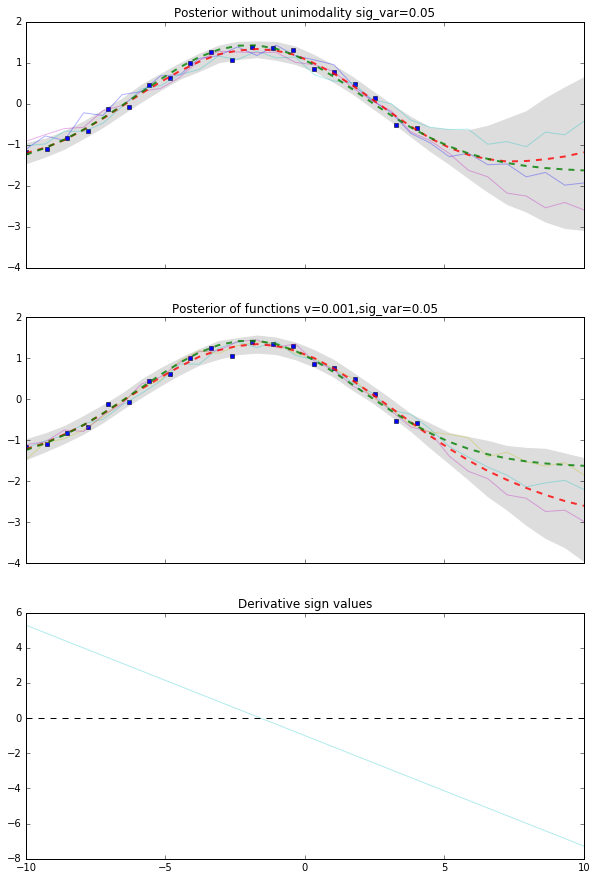

In [155]:
c = ['b', 'c', 'm', 'y']
p = np.random.randint(sim_posterior.shape[0],size=3)
pp = np.random.randint(uni_sim_posterior.shape[0],size=3)


fig,ax = plt.subplots(3,1,sharex=True)
fig.set_size_inches(10,15)
ax[0].set_title('Posterior without unimodality sig_var={}'.format(sig))
ax[0].plot(xdata, ydata, 'bs', ms=4,label="Data points")#  
ax[0].plot(x, sim_posterior[p[0]], c[0],alpha=0.3,label="posterior1")
ax[0].plot(x, sim_posterior[p[1]], c[1],alpha=0.3,label="posterior2")
ax[0].plot(x, sim_posterior[p[2]], c[2],alpha=0.3,label="posterior3")
ax[0].plot(x, p_mean,'r--',alpha=0.8,lw=2,label="mean of posterior simulations")
ax[0].plot(x,y,'g--',alpha=0.8,lw=2,label="Data generating function")
ax[0].fill_between(x, p_q5, p_q95, color="#dddddd")
#ax[0].legend()


#plt.subplot(2,2,2)
ax[1].set_title('Posterior of functions v={},sig_var={}'.format(v,sig))
ax[1].plot(xdata, ydata, 'bs', ms=4,label="Data points")#
ax[1].fill_between(x, u_p_q5, u_p_q95, color="#dddddd")
ax[1].plot(x, uni_sim_posterior[pp[0]], c[1],alpha=0.3,label="posterior-function1")
ax[1].plot(x, uni_sim_posterior[pp[1]], c[2],alpha=0.3,label="posterior-function2")
ax[1].plot(x, uni_sim_posterior[pp[2]], c[3],alpha=0.3,label="posterior-function3")
ax[1].plot(x, u_p_mean, 'r--',alpha=0.8, lw=2,label="mean of posterior simulations")
ax[1].plot(x,y,'g--',alpha=0.8,lw=2,label="Data generating function")
#ax[1].legend()


ax[2].set_title('Derivative sign values')
ax[2].plot(x, u_a*x+u_b, c[1],alpha=0.3,label="posterior-function1")
ax[2].plot(plt.gca().get_xlim(),[0,0],'k--')



plt.savefig("%s Posterior.png"%(time.ctime()))
plt.show()